In [333]:
import numpy as np
import pandas as pd
import sklearn.linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fmin_tnc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

**Titanic**

In [334]:
Titanic=pd.read_csv("Titanic/tested.csv")

In [335]:
Titanic=Titanic.drop(columns=["PassengerId","Ticket","Name"])

In [336]:
Titanic.loc[pd.isna(Titanic.Cabin)==False,"Cabin"]=1

In [337]:
Titanic.loc[pd.isna(Titanic.Cabin)==True,"Cabin"]=0

In [338]:
Titanic.loc[:,"Sex"]=(Titanic.Sex=="male").astype(int)

In [339]:
Titanic.loc[pd.isna(Titanic.Age)==True,"Age"]=Titanic.Age.median()

In [340]:
Titanic=pd.get_dummies(Titanic,columns=["Embarked"], drop_first = True)

In [341]:
Titanic.loc[:,"Cabin"]=Titanic.loc[:,"Cabin"].astype(int)

In [342]:
Titanic = Titanic[~Titanic.isnull().any(axis = 1)]

In [343]:
Titanic = Titanic.drop(columns = ['Sex'])

**Diabets**

In [344]:
Diabetes=pd.read_csv("diabetes/dataset_37_diabetes.csv")

In [345]:
Diabetes.loc[:,"class"]=(Diabetes["class"]=="tested_positive").astype(int)

**Pokemon**

In [346]:
Pokemon=pd.read_csv("Pokemon/pokemon.csv")

In [347]:
Pokemon=Pokemon.filter(regex='^(?!against).*')

In [348]:
Pokemon=Pokemon.drop(columns=["abilities","classfication","pokedex_number","japanese_name","name"])

In [349]:
Pokemon.loc[pd.isna(Pokemon.height_m),"height_m"]=0

In [350]:
Pokemon.loc[pd.isna(Pokemon.percentage_male),"percentage_male"]=0

In [351]:
Pokemon.loc[pd.isna(Pokemon.weight_kg),"weight_kg"]=0

In [352]:
Pokemon.capture_rate=pd.to_numeric(Pokemon.capture_rate,errors="coerce")

In [353]:
Pokemon.loc[pd.isna(Pokemon.capture_rate),"capture_rate"]=255

In [354]:
types1=pd.get_dummies(Pokemon["type1"],columns=["type1"], drop_first = True)

In [355]:
types2=pd.get_dummies(Pokemon["type2"],columns=["type2"], drop_first = True)

In [356]:
Pokemon=Pokemon.drop(columns=["type1","type2"])

In [357]:
Pokemon=pd.concat([Pokemon,types2+types1], axis=1)

In [358]:
Pokemon=Pokemon[['base_egg_steps', 'base_happiness', 'base_total',
                'percentage_male', 'sp_attack', 'is_legendary']]

**Cancer**

In [359]:
Cancer=pd.read_csv("cancer/wdbc.data",header=None)

In [360]:
Cancer.iloc[:,1]=(Cancer[1]=="M").astype(int)

In [361]:
Cancer=Cancer.drop(columns=[0])

**Bank**

In [362]:
Bank=pd.read_csv("bank/bank.csv",sep=";")

In [363]:
Bank.loc[:,"default"]=(Bank.default=="yes").astype(int)

In [364]:
Bank.loc[:,"housing"]=(Bank.housing=="yes").astype(int)

In [365]:
Bank.loc[:,"loan"]=(Bank.loan=="yes").astype(int)

In [366]:
Bank.loc[:,"y"]=(Bank.y=="yes").astype(int)

In [367]:
Bank=pd.get_dummies(Bank, drop_first = True)

**Model assessement**

In [368]:
def accuracy(Y,Y_hat):
    temp=Y==Y_hat
    return np.mean(temp)

In [369]:
def precision(Y,Y_hat):
    tp=np.logical_and(Y,Y_hat)
    fp=np.logical_and(np.logical_not(Y),Y_hat)
    return np.sum(tp)/(np.sum(tp)+np.sum(fp))

In [370]:
def recall(Y,Y_hat):
    tp=np.logical_and(Y,Y_hat)
    fn=np.logical_and(Y,np.logical_not(Y_hat))
    return np.sum(tp)/(np.sum(tp)+np.sum(fn))

In [371]:
def F_measure(Y,Y_hat):
    pre=precision(Y,Y_hat)
    re=recall(Y,Y_hat)
    return 2*pre*re/(pre+re)

In [372]:
def assess(Y, Y_hat):
    print('Acccuracy: ', accuracy(Y, Y_hat))
    print('Precision: ', precision(Y, Y_hat))
    print('Recall: ', recall(Y, Y_hat))
    print('F_measure: ', F_measure(Y, Y_hat))
    print('R2_score: ', r2_score(Y, Y_hat))

**Auxiliary Gradient Descent Functions**

In [373]:
def MSE(Y,Y_hat):
    return np.sum((Y-Y_hat)**2)

def MSE_grad(Y,Y_hat):
     return Y_hat-Y

def sigmoid(x):
    return(1/(1 + np.exp(np.clip(-x,-100,100))))

def sigmoid_grad(x):
    return(sigmoid(x)*(1-sigmoid(x)))

def cross_entropy(Y, Y_hat,  epsilon=1e-10):
    Y_hat = np.clip(Y_hat, epsilon, 1-epsilon)
    return -np.sum(np.log(Y_hat) * Y + np.log((1 - Y_hat)) * (1 - Y))

def cross_entropy_grad(Y,Y_hat,eps=10**-10):
    Y_hat=Y_hat+eps
    return (Y_hat-eps-Y)/Y_hat/(1-Y_hat)

In [374]:
class LogisticRegression:
    
    def __init__(self, solver: str, intercept: bool = True, iterations: int = 1000, 
                 alpha: int = None, batch_size: int = None, eps: float = 10**-8,
                 normalize: bool = False, tol: float = 0.0001):
        
        
        self.solver = solver
        self.intercept = intercept
        self.iterations = iterations
        self.batch_size = batch_size
        self.alpha = alpha
        self.normalize = normalize
        self.tolerance = tol
        self.epsilon = eps
        
    def fit(self, X, Y, verbose = False, save_errors = False):

        if self.normalize:
            self.std = X.std(0)
            self.mean = X.mean(0)
            X = (X-self.mean)/self.std
            
        if self.intercept:
            X = np.insert(X, 0, values=1, axis=1)
            
        self.Beta=np.zeros(X.shape[1])
        
        if self.solver == 'gd':
            self._gradient_descent(X, Y, X.shape[0], verbose, save_errors)
        elif self.solver == 'sgd':
            self._gradient_descent(X, Y, self.batch_size, verbose, save_errors)
        elif self.solver == 'powell':
            self._powell(X, Y)
        else:
            self._iwls(X, Y, verbose, save_errors)
    
    def _gradient_descent(self, X, Y, batch_size, verbose, save_errors):
        
        batches = np.linspace(0,X.shape[0],int(X.shape[0]/batch_size)+1).astype(int)
        
        if save_errors:
            self.errors = [cross_entropy(Y, sigmoid(X @ self.Beta))]
        
        for epoch in range(self.iterations):
            s = np.arange(0, X.shape[0], 1)
            np.random.shuffle(s)
            
            X = X[s,:]
            Y = Y[s]
            
            for b in range(len(batches)-1):
                X_b=X[batches[b]:batches[b+1],:]
                Y_b=Y[batches[b]:batches[b+1]]
                
                pred=sigmoid(X_b @ self.Beta)
                error=cross_entropy(Y_b,pred)
                
                delta = self.alpha * (X_b*(cross_entropy_grad(Y_b,pred) * sigmoid_grad(X_b @ self.Beta)).reshape(-1,1)).mean(axis=0)
                if abs(delta.max()) < self.tolerance:
                    return

                self.Beta = self.Beta - delta
                
            pred=sigmoid(X @ self.Beta)
            error=cross_entropy(Y,pred)
            
            if save_errors:
                self.errors.append(error)
            
            if verbose: 
                print('Iteration no.', epoch+1, ':', error)
                
    
    def _iwls(self, X, Y, verbose, save_errors):
        
        W = np.ones(X.shape[0])*0.5
        X1 = X[:,1:] if self.intercept else X
        
        if save_errors:
            self.errors = [cross_entropy(Y, sigmoid(X @ self.Beta))]
        
        for i in range(self.iterations):
            
            delta = np.linalg.inv((X.T * W[:,None].T) @ X) @ X.T @ (Y-self.predict(X1, _internal_pass = True))
            if abs(delta.max()) < self.tolerance:
                return
            
            self.Beta += delta

            W = (1-self.predict(X1, _internal_pass = True)) * self.predict(X1, _internal_pass = True) + self.epsilon
            
            pred = sigmoid(X @ self.Beta)
            error = cross_entropy(Y, pred)
            
            if save_errors:
                self.errors.append(error)
            
            if verbose: 
                print('Iteration no.', i+1, ':', error)

    def _powell(self, X, Y):
        self.Beta = minimize(fun = lambda x: -cross_entropy(Y, sigmoid(X @ x)), x0 = self.Beta, 
                             method = 'Powell',options={'xtol': self.tolerance, 'maxiter': self.iterations}).x
    
    def predict(self, X, rounding = False, _internal_pass = False):
        
        if (not _internal_pass) and self.normalize:
            X = (X-self.mean)/self.std
            
        if self.intercept:
            X = np.insert(X, 0, values=1, axis=1)
            
        ret = np.exp(np.clip(X @ self.Beta, -100, 100))/(1+np.exp(np.clip(X @ self.Beta, -100, 100)))
        
        if rounding:
            ret = ret.round()

        return ret
    

**Cancer**

In [375]:
np.random.seed(111)
Y = Cancer[1].to_numpy()
X = Cancer.loc[:,2:].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [376]:
mod_sgd = LogisticRegression('sgd', alpha = 0.1, batch_size = 100, normalize = True)
mod_sgd.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

Iteration no. 1 : 158.88853543873998
Iteration no. 2 : 122.54836267002526
Iteration no. 3 : 104.79193869519422
Iteration no. 4 : 93.67644596285164
Iteration no. 5 : 85.90976234839403
Iteration no. 6 : 80.08481651554257
Iteration no. 7 : 75.51958904525705
Iteration no. 8 : 71.82854021656377
Iteration no. 9 : 68.76492051604058
Iteration no. 10 : 66.17791351147598
Iteration no. 11 : 63.957563323457165
Iteration no. 12 : 62.02569002942504
Iteration no. 13 : 60.324667858113195
Iteration no. 14 : 58.81309073005618
Iteration no. 15 : 57.46085282318394
Iteration no. 16 : 56.239009970225396
Iteration no. 17 : 55.130403575841626
Iteration no. 18 : 54.11913544449864
Iteration no. 19 : 53.19089326194663
Iteration no. 20 : 52.33531202889323
Iteration no. 21 : 51.54382643547268
Iteration no. 22 : 50.80868885532783
Iteration no. 23 : 50.12300838871187
Iteration no. 24 : 49.482976662357835
Iteration no. 25 : 48.88278435917549
Iteration no. 26 : 48.31781844764684
Iteration no. 27 : 47.78605109731273
It

In [377]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.9824561403508771
Precision:  0.9772727272727273
Recall:  0.9772727272727273
F_measure:  0.9772727272727273
R2_score:  0.925974025974026


In [378]:
mod_gd = LogisticRegression('gd', alpha = 0.1, normalize = True)
mod_gd.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

Iteration no. 1 : 238.39442025702206
Iteration no. 2 : 199.1838275567015
Iteration no. 3 : 175.15119005756745
Iteration no. 4 : 158.58534542023472
Iteration no. 5 : 146.30025239474062
Iteration no. 6 : 136.7273345412594
Iteration no. 7 : 128.99689483808535
Iteration no. 8 : 122.58426869926276
Iteration no. 9 : 117.15231184289806
Iteration no. 10 : 112.47346058728112
Iteration no. 11 : 108.38793270588327
Iteration no. 12 : 104.77984191943087
Iteration no. 13 : 101.56282830820659
Iteration no. 14 : 98.67103678245002
Iteration no. 15 : 96.05324545738671
Iteration no. 16 : 93.6689243421358
Iteration no. 17 : 91.48551795602972
Iteration no. 18 : 89.47652731507092
Iteration no. 19 : 87.62012776469848
Iteration no. 20 : 85.89815438732809
Iteration no. 21 : 84.29534479927877
Iteration no. 22 : 82.79876554582755
Iteration no. 23 : 81.39737166563633
Iteration no. 24 : 80.08166432418673
Iteration no. 25 : 78.84342167415966
Iteration no. 26 : 77.67548509092961
Iteration no. 27 : 76.57158777397484


Iteration no. 405 : 34.44092886723045
Iteration no. 406 : 34.423037061203715
Iteration no. 407 : 34.40520831133666
Iteration no. 408 : 34.3874422335395
Iteration no. 409 : 34.369738446918205
Iteration no. 410 : 34.352096574440765
Iteration no. 411 : 34.33451624203798
Iteration no. 412 : 34.31699707829932
Iteration no. 413 : 34.29953871553157
Iteration no. 414 : 34.28214078912231
Iteration no. 415 : 34.26480293756296
Iteration no. 416 : 34.24752480242174
Iteration no. 417 : 34.23030602831166
Iteration no. 418 : 34.21314626285776
Iteration no. 419 : 34.19604515666441
Iteration no. 420 : 34.17900236328286
Iteration no. 421 : 34.1620175391791
Iteration no. 422 : 34.14509034370225
Iteration no. 423 : 34.12822043905324
Iteration no. 424 : 34.11140749025391
Iteration no. 425 : 34.09465116511657
Iteration no. 426 : 34.07795113421386
Iteration no. 427 : 34.06130707084912
Iteration no. 428 : 34.04471865102704
Iteration no. 429 : 34.02818555342478
Iteration no. 430 : 34.01170745936338
Iteration n

Iteration no. 838 : 29.893902950755226
Iteration no. 839 : 29.88750404905519
Iteration no. 840 : 29.88111580551113
Iteration no. 841 : 29.874738189085175
Iteration no. 842 : 29.86837116886504
Iteration no. 843 : 29.862014714063363
Iteration no. 844 : 29.855668794017067
Iteration no. 845 : 29.849333378186675
Iteration no. 846 : 29.84300843615572
Iteration no. 847 : 29.836693937630052
Iteration no. 848 : 29.830389852437214
Iteration no. 849 : 29.824096150525826
Iteration no. 850 : 29.81781280196494
Iteration no. 851 : 29.81153977694342
Iteration no. 852 : 29.805277045769305
Iteration no. 853 : 29.79902457886923
Iteration no. 854 : 29.792782346787764
Iteration no. 855 : 29.786550320186834
Iteration no. 856 : 29.780328469845117
Iteration no. 857 : 29.774116766657414
Iteration no. 858 : 29.767915181634088
Iteration no. 859 : 29.761723685900435
Iteration no. 860 : 29.755542250696124
Iteration no. 861 : 29.749370847374582
Iteration no. 862 : 29.743209447402435
Iteration no. 863 : 29.737058022

In [379]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.9736842105263158
Precision:  0.9767441860465116
Recall:  0.9545454545454546
F_measure:  0.9655172413793104
R2_score:  0.888961038961039


In [380]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-6)
mod_iwls.fit(X_train, Y_train, verbose = True, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

Iteration no. 1 : 179.03412927320997
Iteration no. 2 : 87.78824330381084
Iteration no. 3 : 52.682820936331524
Iteration no. 4 : 34.924794025123575
Iteration no. 5 : 24.84174200100493
Iteration no. 6 : 17.401738579899735
Iteration no. 7 : 10.731459574525385
Iteration no. 8 : 6.137317083710444
Iteration no. 9 : 2.907393725265788
Iteration no. 10 : 1.232189404937082
Iteration no. 11 : 0.5280352783840314
Iteration no. 12 : 0.25745655194712114
Iteration no. 13 : 0.14794630370453932
Iteration no. 14 : 0.09768520655388861
Iteration no. 15 : 0.07106526422893836
Iteration no. 16 : 0.05517797243710333
Iteration no. 17 : 0.04481179647394013
Iteration no. 18 : 0.03758749548822466
Iteration no. 19 : 0.03229635263578271
Iteration no. 20 : 0.02826930564260975
Iteration no. 21 : 0.025109728270150233
Iteration no. 22 : 0.022569094930555547
Iteration no. 23 : 0.020484438179985423
Iteration no. 24 : 0.018744778405568003
Iteration no. 25 : 0.017272094967547988
Iteration no. 26 : 0.016010029539991772
Itera

Iteration no. 250 : 0.0008936834184860458
Iteration no. 251 : 0.0008899168323933591
Iteration no. 252 : 0.0008861818345170804
Iteration no. 253 : 0.0008824780294029047
Iteration no. 254 : 0.000878805028165312
Iteration no. 255 : 0.0008751624483555414
Iteration no. 256 : 0.0008715499138243481
Iteration no. 257 : 0.0008679670545981944
Iteration no. 258 : 0.0008644135067480024
Iteration no. 259 : 0.0008608889122687882
Iteration no. 260 : 0.0008573929189591852
Iteration no. 261 : 0.0008539251803066303
Iteration no. 262 : 0.0008504853553667758
Iteration no. 263 : 0.0008470731086612242
Iteration no. 264 : 0.000843688110057717
Iteration no. 265 : 0.0008403300346770844
Iteration no. 266 : 0.0008369985627754354
Iteration no. 267 : 0.0008336933796526615
Iteration no. 268 : 0.0008304141755511689
Iteration no. 269 : 0.0008271606455565019
Iteration no. 270 : 0.0008239324895067345
Iteration no. 271 : 0.0008207294118977558
Iteration no. 272 : 0.0008175511217927735
Iteration no. 273 : 0.00081439733274

Iteration no. 521 : 0.00041611787578057114
Iteration no. 522 : 0.00041529869592238486
Iteration no. 523 : 0.000414482734005926
Iteration no. 524 : 0.000413669971111781
Iteration no. 525 : 0.0004128603884699807
Iteration no. 526 : 0.000412053967456004
Iteration no. 527 : 0.0004112506895899998
Iteration no. 528 : 0.000410450536538009
Iteration no. 529 : 0.0004096534901057465
Iteration no. 530 : 0.00040885953224259843
Iteration no. 531 : 0.00040806864503529334
Iteration no. 532 : 0.0004072808107094565
Iteration no. 533 : 0.0004064960116275007
Iteration no. 534 : 0.0004057142302874047
Iteration no. 535 : 0.00040493544932326814
Iteration no. 536 : 0.00040415965149809513
Iteration no. 537 : 0.00040338681971056656
Iteration no. 538 : 0.00040261693698848963
Iteration no. 539 : 0.00040184998648713245
Iteration no. 540 : 0.00040108595149288776
Iteration no. 541 : 0.00040032481541716643
Iteration no. 542 : 0.0003995665617957314
Iteration no. 543 : 0.00039881117429180636
Iteration no. 544 : 0.0003

Iteration no. 795 : 0.0002701137114729055
Iteration no. 796 : 0.00026976823395220004
Iteration no. 797 : 0.00026942363894182043
Iteration no. 798 : 0.00026907992306525436
Iteration no. 799 : 0.0002687370829641978
Iteration no. 800 : 0.0002683951152950022
Iteration no. 801 : 0.0002680540167331157
Iteration no. 802 : 0.00026771378397041814
Iteration no. 803 : 0.00026737441371511053
Iteration no. 804 : 0.0002670359026916035
Iteration no. 805 : 0.000266698247642072
Iteration no. 806 : 0.0002663614453240127
Iteration no. 807 : 0.0002660254925112431
Iteration no. 808 : 0.000265690385995789
Iteration no. 809 : 0.00026535612258344357
Iteration no. 810 : 0.0002650226990978751
Iteration no. 811 : 0.00026469011237740744
Iteration no. 812 : 0.00026435835927624137
Iteration no. 813 : 0.0002640274366648983
Iteration no. 814 : 0.0002636973414295545
Iteration no. 815 : 0.0002633680704713749
Iteration no. 816 : 0.0002630396207072899
Iteration no. 817 : 0.0002627119890703289
Iteration no. 818 : 0.000262

In [381]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.9298245614035088
Precision:  0.9090909090909091
Recall:  0.9090909090909091
F_measure:  0.9090909090909091
R2_score:  0.7038961038961039


In [382]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [383]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.9298245614035088
Precision:  0.9090909090909091
Recall:  0.9090909090909091
F_measure:  0.9090909090909091
R2_score:  0.7038961038961039


In [384]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [385]:
assess(Y_test, Y_hat)

Acccuracy:  0.9649122807017544
Precision:  0.9761904761904762
Recall:  0.9318181818181818
F_measure:  0.9534883720930233
R2_score:  0.851948051948052


In [386]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [387]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.956140350877193
Precision:  1.0
Recall:  0.8863636363636364
F_measure:  0.9397590361445783
R2_score:  0.814935064935065


In [388]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [389]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.9736842105263158
Precision:  0.9361702127659575
Recall:  1.0
F_measure:  0.967032967032967
R2_score:  0.888961038961039


In [390]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [391]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.9824561403508771
Precision:  0.9772727272727273
Recall:  0.9772727272727273
F_measure:  0.9772727272727273
R2_score:  0.925974025974026


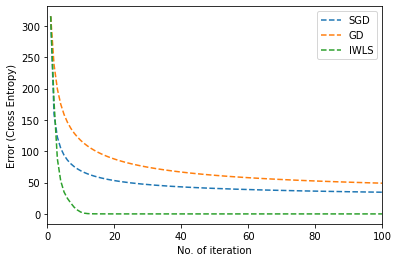

In [392]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Error (Cross Entropy)')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.xlim(0,100)
plt.show()

In [393]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

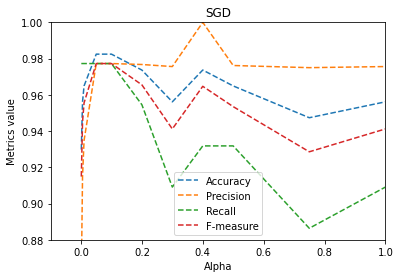

In [394]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.xlim(-0.1,1)
plt.ylim(0.88,1)
plt.title("SGD")
plt.show()

In [395]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

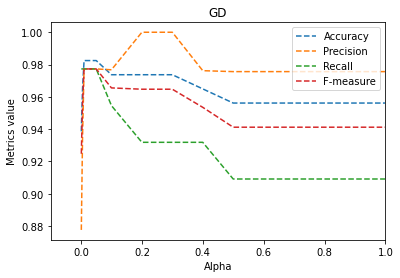

In [396]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.xlim(-0.1,1)
plt.title("GD")
plt.show()

**Bank**

In [397]:
np.random.seed(111)
Y = Bank['y'].to_numpy()
X = Bank.drop(columns=['y']).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [398]:
mod_sgd = LogisticRegression('sgd', alpha = 0.5, batch_size = 1000, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [399]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [400]:
mod_gd = LogisticRegression('gd', alpha = 0.5, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [401]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [402]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-8)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [403]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [404]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [405]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [406]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [407]:
assess(Y_test, Y_hat)

Acccuracy:  0.8994475138121547
Precision:  0.717948717948718
Recall:  0.25925925925925924
F_measure:  0.38095238095238093
R2_score:  0.04322923927691824


In [408]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [409]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.8983425414364641
Precision:  0.6142857142857143
Recall:  0.39814814814814814
F_measure:  0.48314606741573035
R2_score:  0.032715274873367894


In [410]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [411]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.8519337016574585
Precision:  0.3984375
Recall:  0.4722222222222222
F_measure:  0.43220338983050843
R2_score:  -0.4088712300757469


In [412]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [413]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.8883977900552487
Precision:  0.5945945945945946
Recall:  0.2037037037037037
F_measure:  0.30344827586206896
R2_score:  -0.061910404758585225


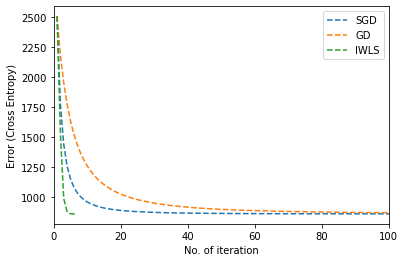

In [414]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Error (Cross Entropy)')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.xlim(0,100)
plt.show()

In [239]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

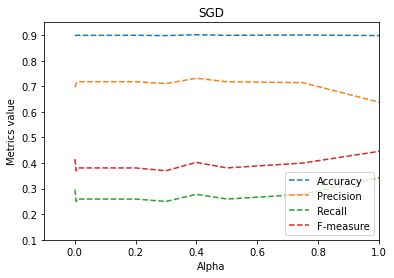

In [246]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("SGD")
plt.xlim(-0.1,1)
plt.ylim(0.1,0.95)
plt.show()

In [247]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

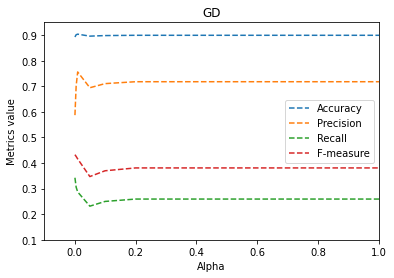

In [248]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("GD")
plt.xlim(-0.1,1)
plt.ylim(0.1,0.95)
plt.show()

**Pokemon**

In [415]:
np.random.seed(111)
Y = Pokemon["is_legendary"].to_numpy()
X = Pokemon.drop(columns=["is_legendary"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [416]:
mod_sgd = LogisticRegression('sgd', alpha = 0.01, batch_size = 200, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [417]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [418]:
mod_gd = LogisticRegression('gd', alpha = 0.01, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [419]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [420]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-6)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [421]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.9627329192546584
Precision:  0.7142857142857143
Recall:  0.8333333333333334
F_measure:  0.7692307692307692
R2_score:  0.45973154362416113


In [422]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [423]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.9627329192546584
Precision:  0.7142857142857143
Recall:  0.8333333333333334
F_measure:  0.7692307692307692
R2_score:  0.45973154362416113


In [424]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [425]:
assess(Y_test, Y_hat)

Acccuracy:  0.9751552795031055
Precision:  0.8333333333333334
Recall:  0.8333333333333334
F_measure:  0.8333333333333334
R2_score:  0.639821029082774


In [426]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [427]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.9813664596273292
Precision:  0.9090909090909091
Recall:  0.8333333333333334
F_measure:  0.8695652173913043
R2_score:  0.7298657718120806


In [428]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [429]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.9565217391304348
Precision:  0.6666666666666666
Recall:  0.8333333333333334
F_measure:  0.7407407407407408
R2_score:  0.3696868008948546


In [430]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [431]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.9751552795031055
Precision:  0.8333333333333334
Recall:  0.8333333333333334
F_measure:  0.8333333333333334
R2_score:  0.639821029082774


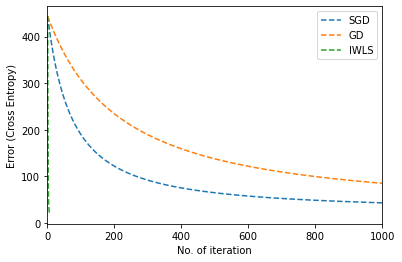

In [432]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Error (Cross Entropy)')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.xlim(0,1000)
plt.show()

In [433]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

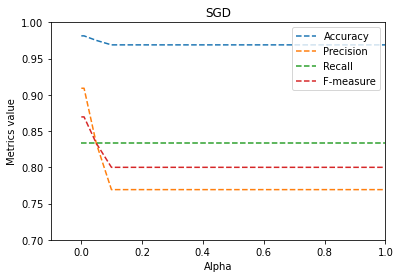

In [436]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("SGD")
plt.xlim(-0.1,1)
plt.ylim(0.7,1,1)
plt.show()

In [437]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

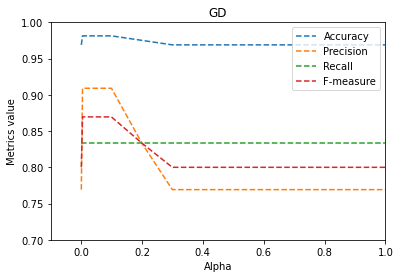

In [438]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("GD")
plt.xlim(-0.1,1)
plt.ylim(0.7,1,1)
plt.show()

**Diabetes**

In [439]:
np.random.seed(111)
Y = Diabetes["class"].to_numpy()
X = Diabetes.drop(columns=["class"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [440]:
mod_sgd = LogisticRegression('sgd', alpha = 0.5, batch_size = 200, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [441]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [442]:
mod_gd = LogisticRegression('gd',alpha = 0.01, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [443]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.7272727272727273
Precision:  0.6222222222222222
Recall:  0.5283018867924528
F_measure:  0.5714285714285715
R2_score:  -0.20829441434709484


In [444]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-5)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [445]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [446]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [447]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [448]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [449]:
assess(Y_test, Y_hat)

Acccuracy:  0.7597402597402597
Precision:  0.66
Recall:  0.6226415094339622
F_measure:  0.6407766990291262
R2_score:  -0.06444984121053587


In [450]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [451]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.7467532467532467
Precision:  0.6666666666666666
Recall:  0.5283018867924528
F_measure:  0.5894736842105263
R2_score:  -0.12198767046515946


In [452]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [453]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.7337662337662337
Precision:  0.6153846153846154
Recall:  0.6037735849056604
F_measure:  0.6095238095238096
R2_score:  -0.17952549971978304


In [454]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [455]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.6818181818181818
Precision:  0.5384615384615384
Recall:  0.5283018867924528
F_measure:  0.5333333333333333
R2_score:  -0.40967681673827716


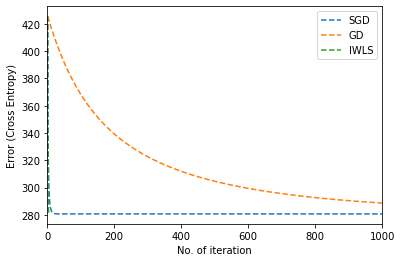

In [458]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Error (Cross Entropy)')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.xlim(0,1000)
plt.show()

In [459]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

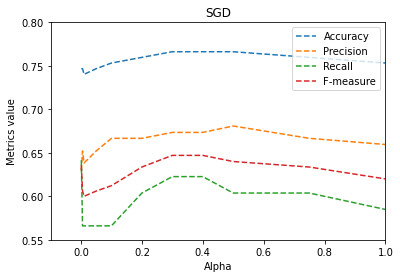

In [462]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("SGD")
plt.xlim(-0.1,1)
plt.ylim(0.55,0.8)
plt.show()

In [463]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

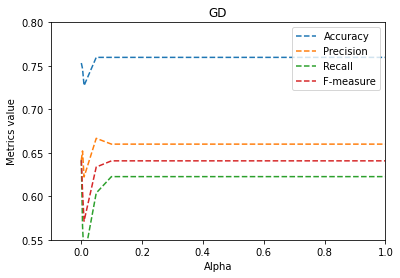

In [464]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("GD")
plt.xlim(-0.1,1)
plt.ylim(0.55,0.8)
plt.show()

**Titanic**

In [465]:
np.random.seed(111)
Y = Titanic["Survived"].to_numpy()
X = Titanic.drop(columns=["Survived"]).to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [466]:
mod_sgd = LogisticRegression('sgd', alpha = 0.1, batch_size = 100, normalize = True)
mod_sgd.fit(X_train, Y_train, save_errors = True)
Y_hat_sgd = mod_sgd.predict(X_test, rounding = True)

In [467]:
assess(Y_test, Y_hat_sgd)

Acccuracy:  0.5238095238095238
Precision:  0.6
Recall:  0.07317073170731707
F_measure:  0.13043478260869565
R2_score:  -0.9058423142370962


In [468]:
mod_gd = LogisticRegression('gd', alpha = 0.1, normalize = True)
mod_gd.fit(X_train, Y_train, save_errors = True)
Y_hat_gd = mod_gd.predict(X_test, rounding = True)

In [469]:
assess(Y_test, Y_hat_gd)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [470]:
mod_iwls = LogisticRegression('iwls', normalize = True, eps = 10**-5)
mod_iwls.fit(X_train, Y_train, save_errors = True)
Y_hat_iwls = mod_iwls.predict(X_test, rounding = True)

In [471]:
assess(Y_test, Y_hat_iwls)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [472]:
mod_powell = LogisticRegression('powell', normalize = True)
mod_powell.fit(X_train, Y_train)
Y_hat_powell = mod_iwls.predict(X_test, rounding = True)

In [473]:
assess(Y_test, Y_hat_powell)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [474]:
X_train_norm, X_test_norm = (X_train-X_train.mean(0))/X_train.std(0), (X_test-X_train.mean(0))/X_train.std(0)
model = sklearn.linear_model.LogisticRegression()
result = model.fit(X_train_norm, Y_train)
Y_hat = result.predict(X_test_norm)

In [475]:
assess(Y_test, Y_hat)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [476]:
mod_lda = LinearDiscriminantAnalysis()
mod_lda = mod_lda.fit(X_train_norm, Y_train)
Y_hat_lda = mod_lda.predict(X_test_norm)

In [477]:
assess(Y_test, Y_hat_lda)

Acccuracy:  0.5238095238095238
Precision:  0.5714285714285714
Recall:  0.0975609756097561
F_measure:  0.16666666666666669
R2_score:  -0.9058423142370962


In [478]:
mod_qda = QuadraticDiscriminantAnalysis()
mod_qda = mod_qda.fit(X_train_norm, Y_train)
Y_hat_qda = mod_qda.predict(X_test_norm)

In [479]:
assess(Y_test, Y_hat_qda)

Acccuracy:  0.5833333333333334
Precision:  0.6363636363636364
Recall:  0.34146341463414637
F_measure:  0.4444444444444445
R2_score:  -0.6676120249574593


In [480]:
mod_knn = KNeighborsClassifier(n_neighbors=5)
mod_knn.fit(X_train_norm, Y_train)
Y_hat_knn = mod_knn.predict(X_test_norm)

In [481]:
assess(Y_test, Y_hat_knn)

Acccuracy:  0.6071428571428571
Precision:  0.6666666666666666
Recall:  0.3902439024390244
F_measure:  0.4923076923076923
R2_score:  -0.5723199092456044


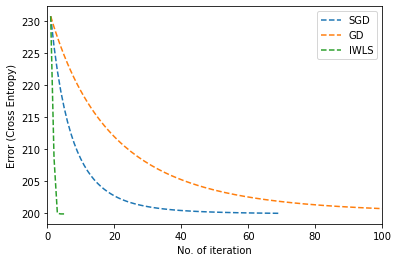

In [482]:
ax = plt.subplot(1,1,1)
plt.plot(list(range(1,len(mod_sgd.errors)+1)), mod_sgd.errors, '--')
plt.plot(list(range(1,len(mod_gd.errors)+1)), mod_gd.errors, '--')
plt.plot(list(range(1,len(mod_iwls.errors)+1)), mod_iwls.errors,'--')
plt.ylabel('Error (Cross Entropy)')
plt.xlabel('No. of iteration')
ax.legend(['SGD', 'GD', 'IWLS'])
plt.xlim(0,100)
plt.show()

In [483]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('sgd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

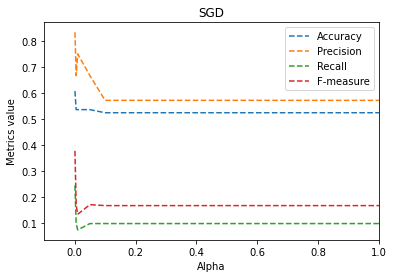

In [487]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("SGD")
plt.xlim(-0.1,1)
plt.show()

In [ ]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 4, 8]
accuracies = []
precisions = []
recalls = []
f_measures = []

for alpha in alphas:
    current_model = LogisticRegression('gd', alpha = alpha, batch_size = 200, normalize = True)
    current_model.fit(X_train, Y_train)
    cur_Y_hat = current_model.predict(X_test, rounding = True)
    accuracies.append(accuracy(Y_test, cur_Y_hat))
    precisions.append(precision(Y_test, cur_Y_hat))
    recalls.append(recall(Y_test, cur_Y_hat))
    f_measures.append(F_measure(Y_test, cur_Y_hat))

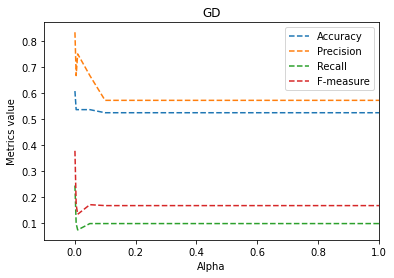

In [489]:
ax = plt.subplot(1,1,1)
plt.plot(alphas, accuracies, '--')
plt.plot(alphas, precisions, '--')
plt.plot(alphas, recalls, '--')
plt.plot(alphas, f_measures, '--')
plt.ylabel('Metrics value')
plt.xlabel('Alpha')
ax.legend(['Accuracy', 'Precision', 'Recall', 'F-measure'])
plt.title("GD")
plt.xlim(-0.1,1)
plt.show()